Ref: Connor Lantz, Behram Radmanesh, Esther Liu, Edward B. Thorp, and Jennie Lin. Single-
cell RNA sequencing uncovers heterogenous transcriptional signatures in macrophages dur-
ing efferocytosis. Scientific Reports, 10(1), 2020.

[GEO Accession GSE156234](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE156234)

In [1]:
from pathlib import Path as path
import warnings
warnings.filterwarnings("ignore") # anndata deprecation warnings related to pandas and numba do not concern us.

In [2]:
import stream as st
st.__version__

'1.0'

In [3]:
st.set_figure_params(
    dpi=120,
    style='white',
    figsize=[5.4,4.8],
    rc={'image.cmap': 'viridis'}
)

In [4]:
%ls raw_data/

GSE122466_Retina_Merged5347cells_RAW.tsv
GSE156234_Macrophages_aggregated_raw_counts.tsv
GSE81682_data_nestorowa2016_raw.tsv


In [5]:
_in_dir = path("raw_data/").resolve()
_publish_dir = path("data_filtered_vargenes/").resolve()
if not _publish_dir.exists():
    _publish_dir.mkdir()
print(f"Reading data from: {_in_dir}")
print(f"Saving processed data to: {_publish_dir}")

Reading data from: /data/raw_data
Saving processed data to: /data/data_filtered_vargenes


In [6]:
infile = _in_dir / 'GSE156234_Macrophages_aggregated_raw_counts.tsv'
infile

PosixPath('/data/raw_data/GSE156234_Macrophages_aggregated_raw_counts.tsv')

In [7]:
outfile = _publish_dir / "GSE156234_Macrophages.csv"
outfile

PosixPath('/data/data_filtered_vargenes/GSE156234_Macrophages.csv')

#### Read in data

In [8]:
%%time 
adata = st.read(file_name=infile.as_posix(), workdir='./stream_result')

Saving results in: ./stream_result
CPU times: user 37.7 s, sys: 956 ms, total: 38.6 s
Wall time: 38.6 s


> **To load and use 10x Genomics single cell RNA-seq data processed with Cell Ranger:**   
(*The variable index can be reset by choosing a different column in `gene.tsv`*)
```python
adata=st.read(file_name='./filtered_gene_bc_matrices/matrix.mtx',
              file_feature='./filtered_gene_bc_matrices/genes.tsv',
              file_sample='./filtered_gene_bc_matrices/barcodes.tsv',
              file_format='mtx',workdir='./stream_result')    
adata.var.index = adata.var[1].values   
```

> **If the Anndata object is already created, to run STREAM, please simply specify work directory:**
```python
st.set_workdir(adata,'./stream_result')
```

In [9]:
adata.obs_names_make_unique()
adata.var_names_make_unique()

In [10]:
adata

AnnData object with n_obs × n_vars = 7760 × 55538 
    uns: 'workdir'

#### Calculate QC

In [11]:
st.cal_qc(adata,assay='rna')

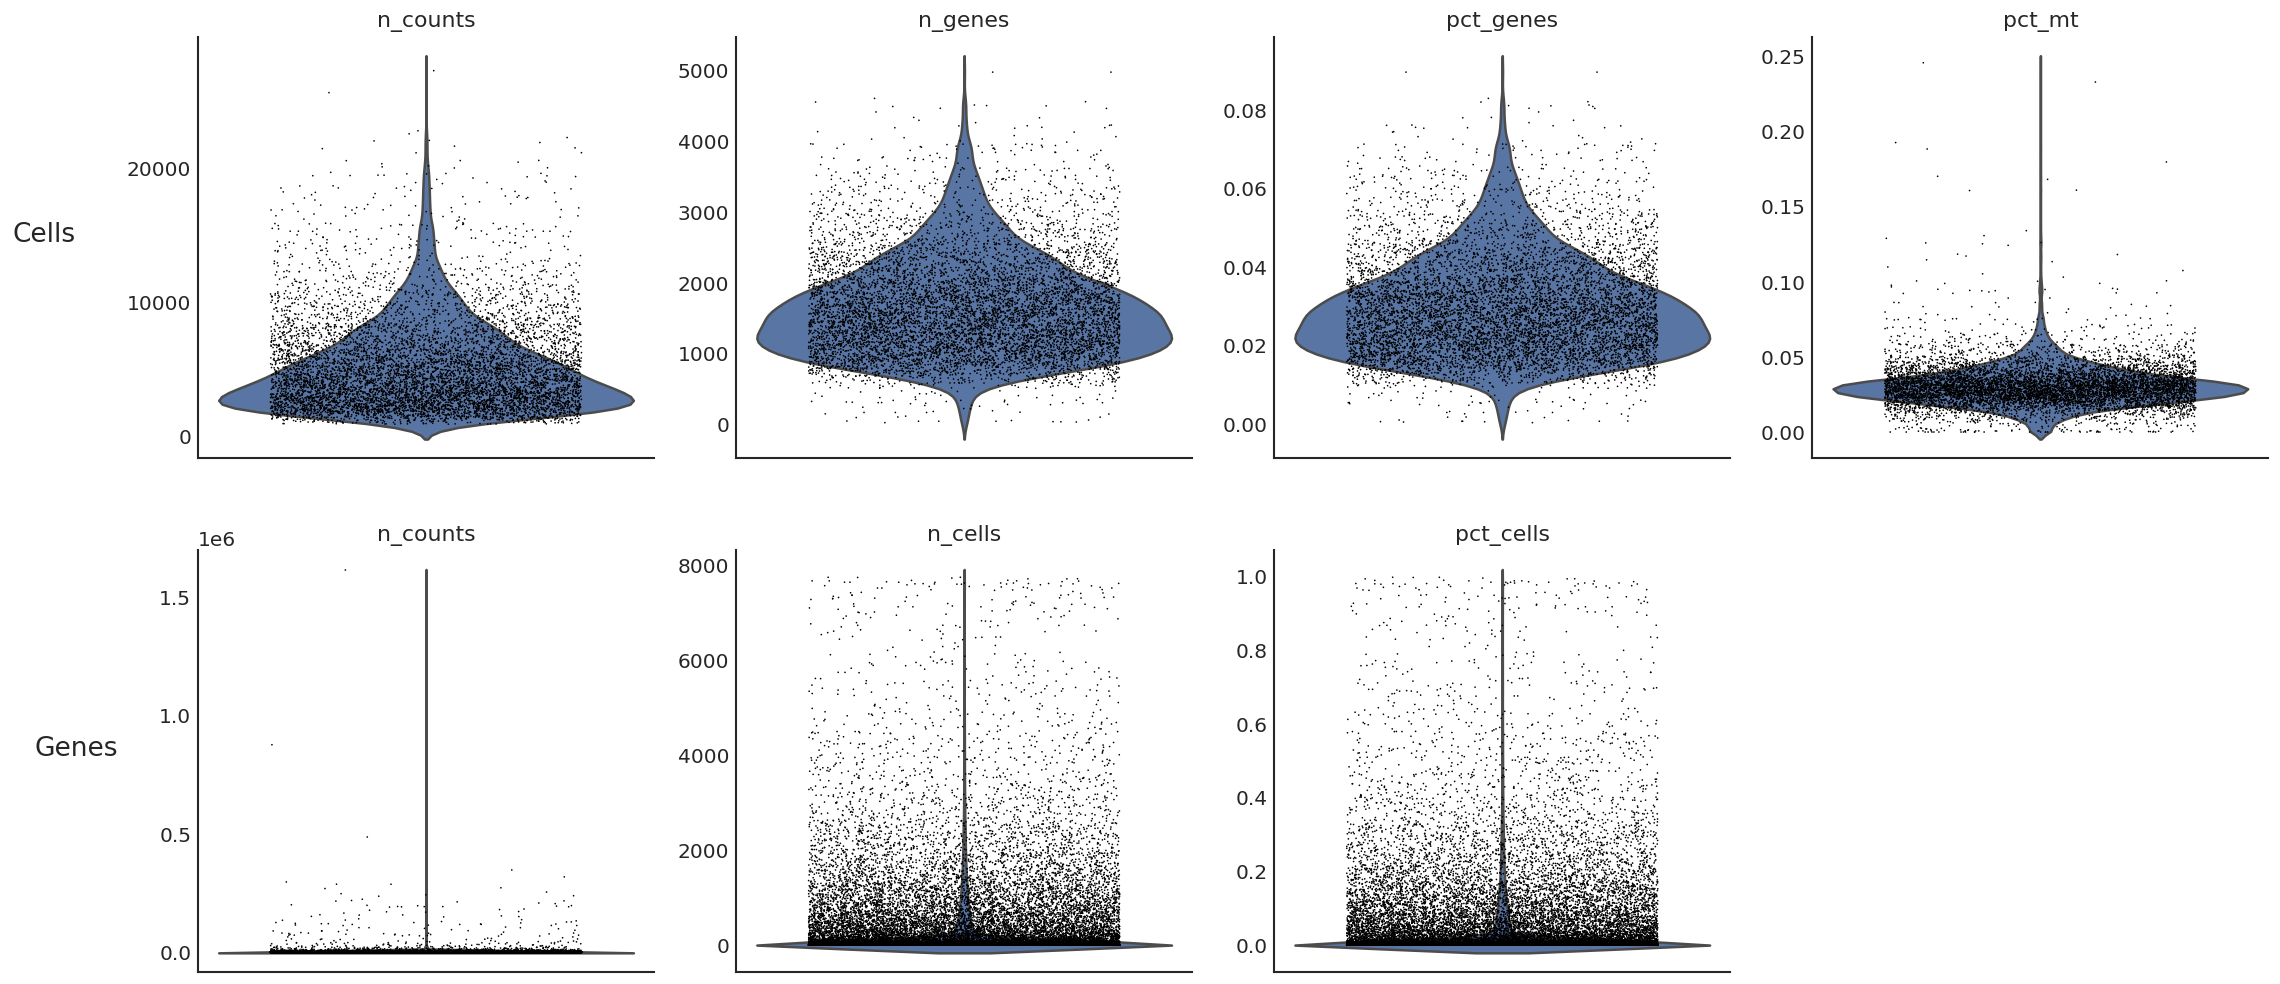

In [12]:
st.plot_qc(adata,jitter=0.3,)

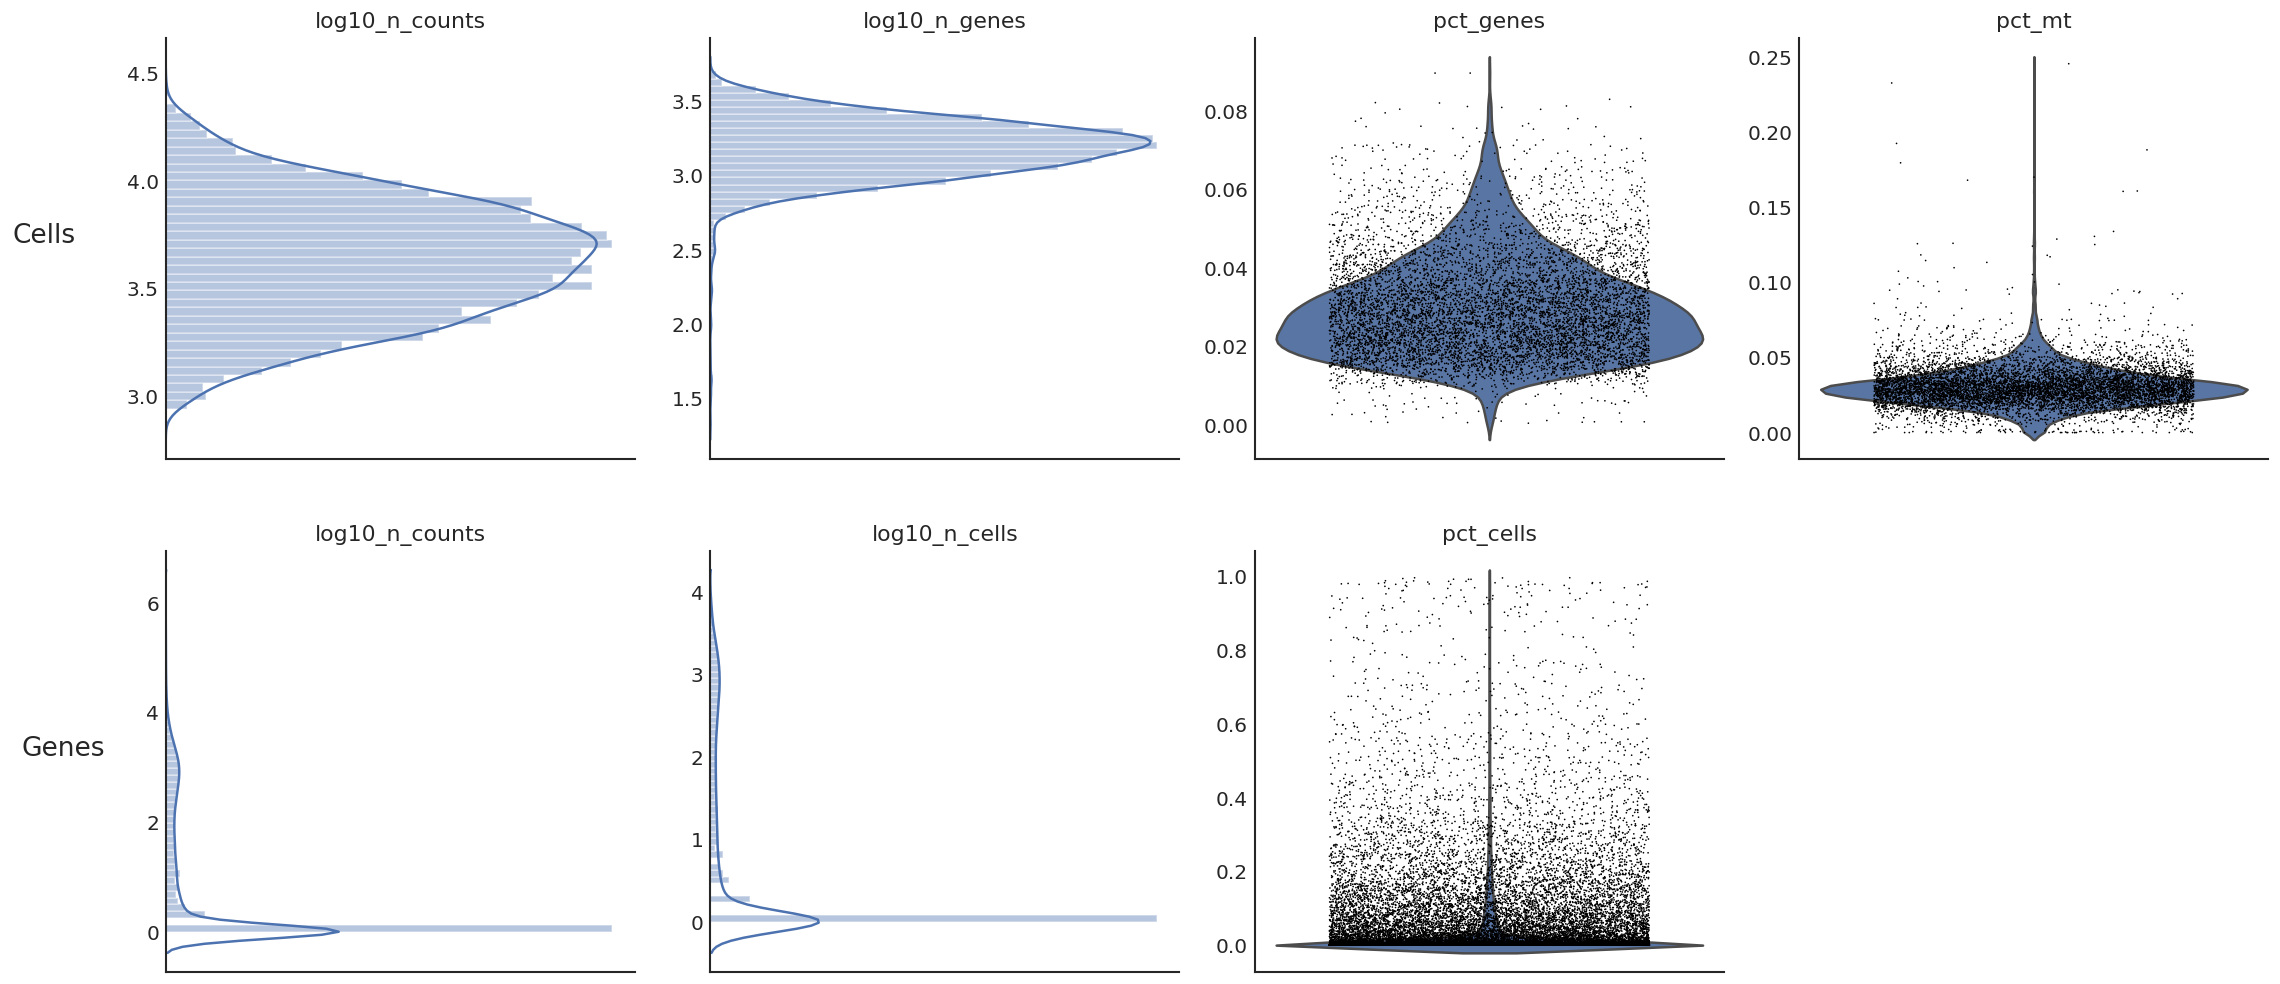

In [13]:
### histogram plots and log-scale are also supported
st.plot_qc(adata,jitter=0.3,log_scale=[0,1,4,5],hist_plot=[0,1,4,5]) 

In [14]:
st.filter_cells(adata, min_n_features= 200)
st.filter_features(adata, min_n_cells = 10)

filter cells based on min_n_features
after filtering out low-quality cells: 
7738 cells, 55538 genes
Filter genes based on min_n_cells
After filtering out low-expressed genes: 
7738 cells, 16365 genes


In [15]:
###Normalize gene expression based on library size  
st.normalize(adata,method='lib_size')
###Logarithmize gene expression 
st.log_transform(adata)
###Remove mitochondrial genes 
st.remove_mt_genes(adata)

remove mitochondrial genes:
['mt-Rnr1', 'mt-Rnr2', 'mt-Nd1', 'mt-Nd2', 'mt-Co1', 'mt-Co2', 'mt-Atp8', 'mt-Atp6', 'mt-Co3', 'mt-Nd3', 'mt-Nd4l', 'mt-Nd4', 'mt-Nd5', 'mt-Nd6', 'mt-Cytb']


#### Feature selection

Please check if the blue curve fits the points well. If not, please adjust the parameter **'loess_frac'** (usually by lowering it) until the blue curve fits well. 

818 variable genes are selected
CPU times: user 3.33 s, sys: 839 ms, total: 4.17 s
Wall time: 5.33 s


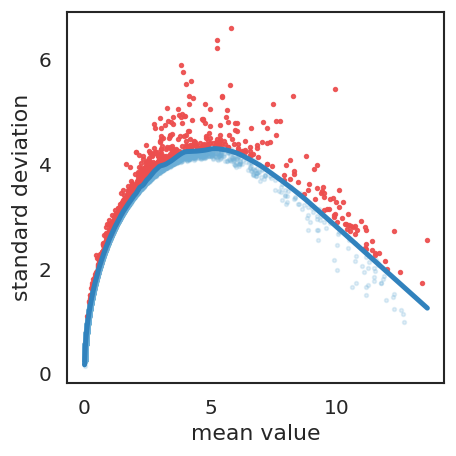

In [16]:
%%time
st.select_variable_genes(adata,loess_frac=0.01,percentile=95)

In [17]:
adata

AnnData object with n_obs × n_vars = 7738 × 16350 
    obs: 'n_counts', 'n_genes', 'pct_genes', 'pct_mt'
    var: 'n_counts', 'n_cells', 'pct_cells'
    uns: 'workdir', 'assay', 'var_genes'
    obsm: 'var_genes'

#### Save most variable genes to a new dataframe

In [18]:
# extract the genes index
var_genes = adata.uns["var_genes"]
var_genes

Index(['Atp6v1h', 'Pcmtd1', 'Gm29216', 'Ptpn18', 'Neurl3', 'Rnf149', 'Map4k4',
       'Stat1', 'Stk17b', 'Nrp2',
       ...
       'P2ry10', 'Diaph2', 'Rpl36a', 'Tsc22d3', 'Acsl4', 'Rpl21-ps15', 'Sat1',
       'Sms', 'G530011O06Rik', 'Gm47283'],
      dtype='object', length=818)

In [19]:
list(_publish_dir.glob("*csv"))

[PosixPath('/data/data_filtered_vargenes/GSE122466_Retina.csv')]

In [20]:
adata.to_df()[var_genes].to_csv(outfile.as_posix())

In [21]:
list(_publish_dir.glob("*csv"))

[PosixPath('/data/data_filtered_vargenes/GSE156234_Macrophages.csv'),
 PosixPath('/data/data_filtered_vargenes/GSE122466_Retina.csv')]